# Fitting XGBoost Classifier

In [3]:
import xgboost
import Data_Helper as DH
import lendingclub
import prediction
import numpy as np
import pandas as pd
import json
import time
import sklearn
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

pd.options.mode.chained_assignment = None  # default='warn'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Instantiate Object

In [4]:
# initialize config object
config = lendingclub.ConfigData("config_data_dummy.ini")

# initialize lendingclup api object
lc = lendingclub.LendingClub(config)

# initialize data transformer
transformer = DH.Transformer_full()

# initialize DataHelper
periodStart = ("Q1", "2014")
periodEnd = ("Q2", "2016")
DataHelper = DH.DataHelper(periodStart, periodEnd, transformer, lc)

In [5]:
# set training data
DataHelper.set_training_dataset()

In [6]:
# set test data
DataHelper.set_test_dataset(["LoanStats_2016Q3.csv", "LoanStats_2016Q4.csv"])

## XGBoost Classifier

In [13]:
xgb = prediction.ModelXGBClassfication()

In [14]:
# get training/test for this model
training, test = xgb.get_data_for_model(DataHelper.training, DataHelper.test)

CHeck multi-thread computing works here!

In [15]:
param = {
    "n_estimators": 500,
    "learning_rate": 0.1,
    "max_depth": 6, 
    "min_child_weight": 1,
    "gamma": 0,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_alpha": 0
}

In [16]:
# Check time
start = time.time()

model = xgb.fit_model(training, **param)
score = xgb.test_model(test, model)
print("Raw test score:",score)

end = time.time()
print(end - start)

Raw test score: {'score': 0.7694472013181604, 'AUC': 0.6890088160582584}
325.6522390842438


## XGBoost Classifier - CV

### Quick train for n_estimators

With default parameters and 0.01 learning rate, quickly fit the n_estimators. This will be fine tuned later.

In [5]:
# instantiate our model
xgb = prediction.ModelXGBClassfication()

In [6]:
# get training/test for this model
training, test = xgb.get_data_for_model(DataHelper.training, DataHelper.test)

In [7]:
# get CVs
CVs = DataHelper.get_cross_validation_data(fold=5)

In [12]:
param = {
    "n_estimators": 5000,
    "learning_rate": 0.01,
    "max_depth": 6, 
    "min_child_weight": 1,
    "gamma": 0,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_alpha": 0
}

In [13]:
param["n_estimators"] = xgb.fit_n_estimator(training, 5, 50, **param)

stop at 3651 test-mean-auc: 0.7138, test-std-auc: 0.0019


### max_depth and min_child_weight

In [ ]:
param_CV = {x:[y] for x,y in param.items()}
param_CV["max_depth"] = list(range(3,10,2))
param_CV["min_child_weight"] = list(range(1,6,2))
grids = xgb.construct_grids(**param_CV)

In [15]:
# tune parameters with CV
scores = xgb.tune_parameters(DataHelper.training, CVs, grids, verbose=False)

In [16]:
# choose best Grid
scores, avg_score, param = xgb.best_grid(scores, "AUC")
print(avg_score)
print("max_depth: {}, min_child_weight: {}".format(param["max_depth"], param["min_child_weight"]))

0.7144746937305857
max_depth: 7, min_child_weight: 1


Further tuning with finer grid...

In [10]:
param_CV = {x:[y] for x,y in param.items()}
param_CV["max_depth"] = [6,7,8]
param_CV["min_child_weight"] = [1,2]
grids = xgb.construct_grids(**param_CV)

In [12]:
# tune parameters with CV
scores = xgb.tune_parameters(DataHelper.training, CVs, grids, verbose=False)

In [13]:
# choose best Grid
scores, avg_score, param = xgb.best_grid(scores, "AUC")
print(avg_score)
print("max_depth: {}, min_child_weight: {}".format(param["max_depth"], param["min_child_weight"]))

0.7144756822625193
max_depth: 6, min_child_weight: 1


### Tune Gamma

In [14]:
param_CV = {x:[y] for x,y in param.items()}
param_CV["gamma"] = [i/10.0 for i in range(0,6)]
grids = xgb.construct_grids(**param_CV)

In [15]:
# tune parameters with CV
scores = xgb.tune_parameters(DataHelper.training, CVs, grids, verbose=False)

In [17]:
# choose best Grid
scores, avg_score, param = xgb.best_grid(scores, "AUC")
print(avg_score)
print("gamma: {}".format(param["gamma"]))

KeyError: 'scores'

In [13]:
param

{'n_estimators': 3651,
 'learning_rate': 0.01,
 'max_depth': 6,
 'min_child_weight': 1,
 'gamma': 0,
 'subsample': 0.5,
 'colsample_bytree': 0.7,
 'reg_alpha': 0}

### Refit the n_estimators

In [ ]:
param["n_estimators"] = xgb.fit_n_estimator(training, 5, 50, **param)

### Tune subsample and colsample_bytree

In [28]:
param_CV = {x:[y] for x,y in param.items()}
param_CV["subsample"] = [i/10 for i in range(5,9)]
param_CV["colsample_bytree"] = [i/10 for i in range(5,9)]
grids = xgb.construct_grids(**param_CV)

In [29]:
# tune parameters with CV
scores = xgb.tune_parameters(DataHelper.training, CVs, grids, verbose=False)

In [30]:
# choose best Grid
new_scores,avg_score, param = xgb.best_grid(scores, "AUC")
print(avg_score)
print("subsample: {}, colsample_bytree: {}".format(param["subsample"], param["colsample_bytree"]))

0.714535854283393
subsample: 0.5, colsample_bytree: 0.7


Further fine tuning..

In [ ]:
param_CV = {x:[y] for x,y in param.items()}
param_CV["subsample"] = [i/100.0 for i in range(55,70,5)]
param_CV["colsample_bytree"] = [i/100.0 for i in range(55,70,5)]
grids = xgb.construct_grids(**param_CV)

In [ ]:
# tune parameters with CV
scores = xgb.tune_parameters(DataHelper.training, CVs, grids, verbose=False)

In [ ]:
# choose best Grid
scores,avg_score, param = xgb.best_grid(scores, "AUC")
print(avg_score)
print("subsample: {}, colsample_bytree: {}".format(param["subsample"], param["colsample_bytree"]))

### Tune Regularization Parameters

In [9]:
param_CV = {x:[y] for x,y in param.items()}
param_CV["reg_alpha"] = [0, 1e-4, 1e-2, 0.1]
grids = xgb.construct_grids(**param_CV)

In [11]:
# tune parameters with CV
scores = xgb.tune_parameters(DataHelper.training, CVs, grids, verbose=False)

In [12]:
# choose best Grid
scores, avg_score, param = xgb.best_grid(scores, "AUC")
print(avg_score)
print("reg_alpha: {}".format(param["reg_alpha"]))

0.714535854283393
reg_alpha: 0


Now apply this parameters to our model and check the AUC.

In [ ]:
model = xgb.fit_model(training, **param)
score = xgb.test_model(test, model)
print("Raw test score:", score)

### Reducing learning rate

Let's decrease the learning rate and increase the n_estimators.

In [14]:
param

{'n_estimators': 3651,
 'learning_rate': 0.01,
 'max_depth': 6,
 'min_child_weight': 1,
 'gamma': 0,
 'subsample': 0.5,
 'colsample_bytree': 0.7,
 'reg_alpha': 0}

In [8]:
param = {
    "n_estimators": 3651,
    "learning_rate": 0.01,
    "max_depth": 6, 
    "min_child_weight": 1,
    "gamma": 0,
    "subsample": 0.5,
    "colsample_bytree": 0.7,
    "reg_alpha": 0
}

In [9]:
param_CV = {x:[y] for x,y in param.items()}
param_CV["n_estimators"] = [3651, 4651, 5651]
grids = xgb.construct_grids(**param_CV)

In [10]:
# tune parameters with CV
scores = xgb.tune_parameters(DataHelper.training, CVs, grids, verbose=False)

In [11]:
# choose best Grid
_, avg_score, param = xgb.best_grid(scores, "AUC")
print(avg_score)
print("learning_rate: {}, n_estimators: {}".format(param["learning_rate"], param["n_estimators"]))

0.714562043934092
learning_rate: 0.01, n_estimators: 3651


In [12]:
# try plot scores !!!!!!

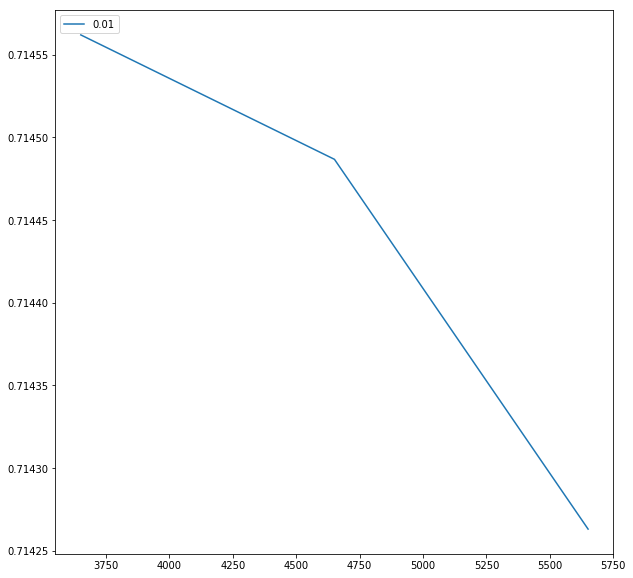

In [13]:
plt.figure(figsize=(10,10))
for lr in param_CV["learning_rate"]:
    aucs = [x["avg_score"]["AUC"] for x in scores if x["grid"]["learning_rate"]==lr]
    plt.plot(param_CV["n_estimators"], aucs)

plt.legend(param_CV["learning_rate"], loc='upper left')
plt.show()

Further tuning..

## Fitting

In [21]:
# initialize config object
config = lendingclub.ConfigData("config_data_dummy.ini")

# initialize lendingclup api object
lc = lendingclub.LendingClub(config)

# initialize data transformer
transformer = DH.Transformer_full()

# initialize DataHelper
periodStart = ("Q1", "2014")
periodEnd = ("Q2", "2016")
DataHelper = DH.DataHelper(periodStart, periodEnd, transformer, lc)

In [22]:
# set training data
DataHelper.set_training_dataset()

In [23]:
# set test data
DataHelper.set_test_dataset(["LoanStats_2016Q3.csv", "LoanStats_2016Q4.csv"])

In [24]:
# instantiate our model
xgb = prediction.ModelXGBClassfication()

In [25]:
# get training/test for this model
training, test = xgb.get_data_for_model(DataHelper.training, DataHelper.test)

In [26]:
param = {
    "n_estimators": 3651,
    "learning_rate": 0.01,
    "max_depth": 6, 
    "min_child_weight": 1,
    "gamma": 0,
    "subsample": 0.5,
    "colsample_bytree": 0.7,
    "reg_alpha": 0
}

In [27]:
# Check time
start = time.time()

model = xgb.fit_model(training, **param)
score = xgb.test_model(test, model)
print("test score:",score)

end = time.time()
print(end - start)

test score: {'score': 0.7679593702790809, 'AUC': 0.6948213159184868}
1506.76624917984


In [28]:
scaler = xgb.get_scaler(DataHelper.training)

## Save Result

In [13]:
filename = "xgb_classification_20190704.sav"

In [14]:
xgb.save_model(model,scaler,training,filename)

Model is saved on xgb_classification_20190704.sav


## Predict listed loan by saved model

In [15]:
filename = "xgb_classification_20190704.sav"

In [16]:
# instantiate from beginning
new_model = prediction.ModelXGBClassfication(filename)

In [17]:
# update from the saved model
new_model.set_model_from_file()

Model is loaded from xgb_classification_20190704.sav


In [18]:
# check model description
new_model.model_description

'XGBoost Classification Object, time: 07/04/2019, eta: 0.01, num_rounds: 3651, max_depth: 6, subsample: 0.5'

In [19]:
# get listed loan
loans = DataHelper.get_listed_loandata()
loans.shape

(92, 81)

In [20]:
# prediction
pred = new_model.predict_model(loans)
pred.shape

(92,)